In [1]:
import itk
from pathlib import Path
import numpy as np
from itkwidgets import view
import SimpleITK as sitk
import multiscale.itk.itk_plotting as iplt
import matplotlib.pyplot as plt

In [2]:
us_path = Path(r'F:\Research\LINK\Phantom Trials\2018-12-07','fused_8bit.tif')
mpm_path = Path(r'F:\Research\LINK\Phantom Trials\2018-12-04', 'MPM Grid shrunk 16x in xy.tif')

In [3]:
us_image = itk.imread(str(us_path))

In [4]:
view(us_image, cmap='Grayscale')

Viewer(cmap='Grayscale', gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Obj…

Box(children=(IntSlider(value=190, description='image slice:', max=380), IntSlider(value=0, description='image…

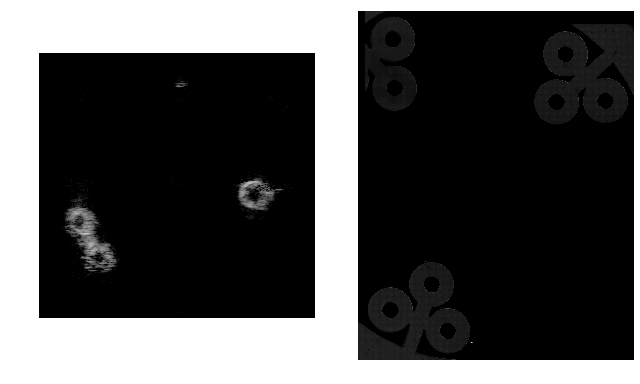

In [5]:
us_image = sitk.ReadImage(str(us_path))
us_image.SetSpacing([25, 25, 25])
mpm_image = sitk.ReadImage(str(mpm_path))
mpm_image.SetSpacing([16, 16, 7.5])

rotated_image = sitk.PermuteAxes(us_image, [2, 0, 1])
rotated_image = sitk.Flip(rotated_image, [False, True, False])
iplt.MultiImageDisplay(image_list=[rotated_image, mpm_image])

In [6]:
size = rotated_image.GetSize()
size_crop = [size[0], size[1], 262-171]
index = [0, 0, 171]
size_crop
size

(1093, 1051, 381)

Box(children=(IntSlider(value=45, description='image slice:', max=90),))

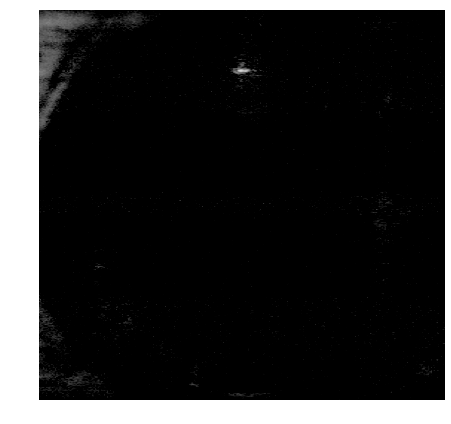

In [7]:
cropped_image = sitk.RegionOfInterest(rotated_image, size_crop, index)
iplt.MultiImageDisplay(image_list=[cropped_image])

In [8]:
edge_image = sitk.SobelEdgeDetection(sitk.Cast(cropped_image, sitk.sitkFloat32))

Box(children=(IntSlider(value=45, description='image slice:', max=90),))

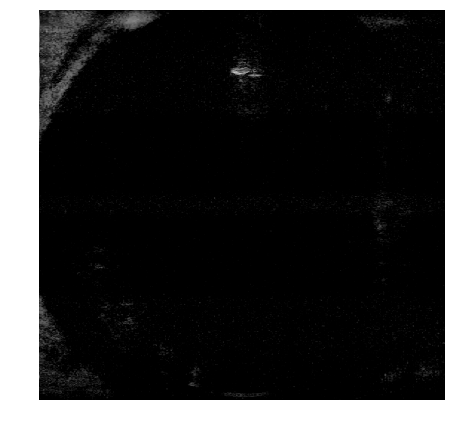

In [9]:
iplt.MultiImageDisplay(image_list=[edge_image])

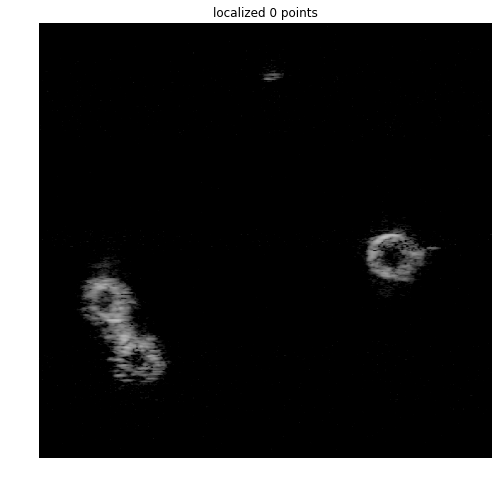

In [10]:
interface = iplt.PointDataAcquisition(rotated_image)

In [ ]:
#initial_seed_point_indexes = interface.get_point_indexes()
#seg_explicit_thresholds = sitk.ConnectedThreshold(rotated_image, seedList=initial_seed_point_indexes, lower=100, upper=255)
thresh_img = cropped_image > 20
cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(thresh_img, [10, 10, 2])
cleaned_thresh_img = sitk.BinaryClosingByReconstruction(cleaned_thresh_img, [10, 10, 2])

iplt.MultiImageDisplay(image_list=[sitk.LabelOverlay(cropped_image, cleaned_thresh_img)], title_list=['Connected threshold'])

In [ ]:
stats = sitk.LabelShapeStatisticsImageFilter()
stats.Execute(sitk.ConnectedComponent(cleaned_thresh_img))
label_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels() if l != 1]

plt.figure()
plt.hist(label_sizes,bins=200)
plt.title("Distribution of Object Sizes")
plt.xlabel("size in pixels")
plt.ylabel("number of objects")
plt.show()

In [ ]:
iplt.MultiImageDisplay(image_list = [sitk.LabelOverlay(cropped_image, sitk.ConnectedComponent(cleaned_thresh_img))],                   
                      title_list = ['Cleaned Binary Segmentation'],figure_size=(8,4));

In [ ]:
dist_img = sitk.SignedMaurerDistanceMap(cleaned_thresh_img != 0, insideIsPositive=False, squaredDistance=False, useImageSpacing=False)
radius = 10
# Seeds have a distance of "radius" or more to the object boundary, they are uniquely labelled.
seeds = sitk.ConnectedComponent(dist_img < -radius)
# Relabel the seed objects using consecutive object labels while removing all objects with less than 15 pixels.
seeds = sitk.RelabelComponent(seeds, minimumObjectSize=15)
# Run the watershed segmentation using the distance map and seeds.
ws = sitk.MorphologicalWatershedFromMarkers(dist_img, seeds, markWatershedLine=True)
ws = sitk.Mask( ws, sitk.Cast(cleaned_thresh_img, ws.GetPixelID()))

In [ ]:
iplt.MultiImageDisplay(image_list = [dist_img,
                                    sitk.LabelOverlay(cropped_image, seeds),
                                    sitk.LabelOverlay(cropped_image, ws)],                   
                      title_list = ['Segmentation Distance',
                                    'Watershed Seeds',
                                    'Binary Watershed Labeling'],
                      shared_slider=True,
                      horizontal=False,
                      figure_size=(6,12));
